# Import libraries and data

In [1]:
# Import Libraries
suppressPackageStartupMessages({

library(tidyverse)  # Collection of packages including dplyr, ggplot2
library(snakecase)  # Converts strings to snake_case format
library(lubridate)  # Simplifies date and time handling
library(naniar)     # Tools for exploring and handling missing data
library(janitor)    # Data cleaning and examination functions
library(caret)      # Machine learning training and evaluation
library(lightgbm)   # Gradient boosting 
    
})

In [2]:
# Import data 
train <- read_csv("/kaggle/input/playground-series-s4e12/train.csv")
test <- read_csv("/kaggle/input/playground-series-s4e12/test.csv")

Rows: 1200000 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): Gender, Marital Status, Education Level, Occupation, Location, Po...
dbl  (10): id, Age, Annual Income, Number of Dependents, Health Score, Previ...
dttm  (1): Policy Start Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 800000 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): Gender, Marital Status, Education Level, Occupation, Location, Po...
dbl   (9): id, Age, Annual Income, Number of Dependents, Health Score, Previ...
dttm  (1): Policy Start Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Explore and clean data

In [3]:
# Inspect the data
summary(train)

# Print the first few rows 
head(train)

       id               Age           Gender          Annual Income   
 Min.   :      0   Min.   :18.00   Length:1200000     Min.   :     1  
 1st Qu.: 300000   1st Qu.:30.00   Class :character   1st Qu.:  8001  
 Median : 600000   Median :41.00   Mode  :character   Median : 23911  
 Mean   : 600000   Mean   :41.15                      Mean   : 32745  
 3rd Qu.: 899999   3rd Qu.:53.00                      3rd Qu.: 44634  
 Max.   :1199999   Max.   :64.00                      Max.   :149997  
                   NA's   :18705                      NA's   :44949   
 Marital Status     Number of Dependents Education Level     Occupation       
 Length:1200000     Min.   :0.00         Length:1200000     Length:1200000    
 Class :character   1st Qu.:1.00         Class :character   Class :character  
 Mode  :character   Median :2.00         Mode  :character   Mode  :character  
                    Mean   :2.01                                              
                    3rd Qu.:3.00     

id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,⋯,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<chr>,<chr>,<chr>,<chr>,<dbl>
0,19,Female,10049,Married,1,Bachelor's,Self-Employed,22.59876,Urban,⋯,2,17,372,5,2023-12-23 15:21:39,Poor,No,Weekly,House,2869
1,39,Female,31678,Divorced,3,Master's,NA,15.56973,Rural,⋯,1,12,694,2,2023-06-12 15:21:39,Average,Yes,Monthly,House,1483
2,23,Male,25602,Divorced,3,High School,Self-Employed,47.17755,Suburban,⋯,1,14,NA,3,2023-09-30 15:21:39,Good,Yes,Weekly,House,567
3,21,Male,141855,Married,2,Bachelor's,NA,10.93814,Rural,⋯,1,0,367,1,2024-06-12 15:21:39,Poor,Yes,Daily,Apartment,765
4,21,Male,39651,Single,1,Bachelor's,Self-Employed,20.37609,Rural,⋯,0,8,598,4,2021-12-01 15:21:39,Poor,Yes,Weekly,House,2022
5,29,Male,45963,Married,1,Bachelor's,NA,33.05320,Urban,⋯,2,4,614,5,2022-05-20 15:21:39,Average,No,Weekly,House,3202


In [4]:
# Convert column names to snake_case
train <- clean_names(train)

# Clean apostrophes and convert to snake_case
train$education_level <- gsub("'", "", train$education_level)
train$education_level <- snakecase::to_snake_case(train$education_level)
train$occupation <- snakecase::to_snake_case(train$occupation)

In [5]:
# Replace empty rows with NA
train <- train %>%
  mutate(
    education_level = ifelse(education_level == "" | is.na(education_level), NA, education_level),
    occupation = ifelse(occupation == "" | is.na(occupation), NA, occupation)
  )
# Check
empty_education <- sum(train$education_level == "" | is.na(train$education_level))
empty_occupation <- sum(train$occupation == "" | is.na(train$occupation))

if (empty_education > 0 | empty_occupation > 0) {
  warning("Some empty strings or NA values are still present")
  cat("Empty or NA in education_level:", empty_education, "\n")
  cat("Empty or NA in occupation:", empty_occupation, "\n")
}

Warning message in eval(expr, envir, enclos):
“Some empty strings or NA values are still present”


Empty or NA in education_level: 0 
Empty or NA in occupation: 358075 


In [6]:
# Save original dataset
train_before <- train

# Impute
train_clean <- train %>%
  # Handle missing values
  mutate(
    age = ifelse(is.na(age), median(age, na.rm = TRUE), age),
    annual_income = ifelse(is.na(annual_income), median(annual_income, na.rm = TRUE), annual_income),
    health_score = ifelse(is.na(health_score), mean(health_score, na.rm = TRUE), health_score),
    credit_score = ifelse(is.na(credit_score), median(credit_score, na.rm = TRUE), credit_score),
    number_of_dependents = ifelse(
      is.na(number_of_dependents), 
      as.numeric(names(sort(table(number_of_dependents), decreasing = TRUE)[1])), 
      number_of_dependents
    ),
    previous_claims = ifelse(is.na(previous_claims), 0, previous_claims),
    vehicle_age = ifelse(is.na(vehicle_age), median(vehicle_age, na.rm = TRUE), vehicle_age)
    )

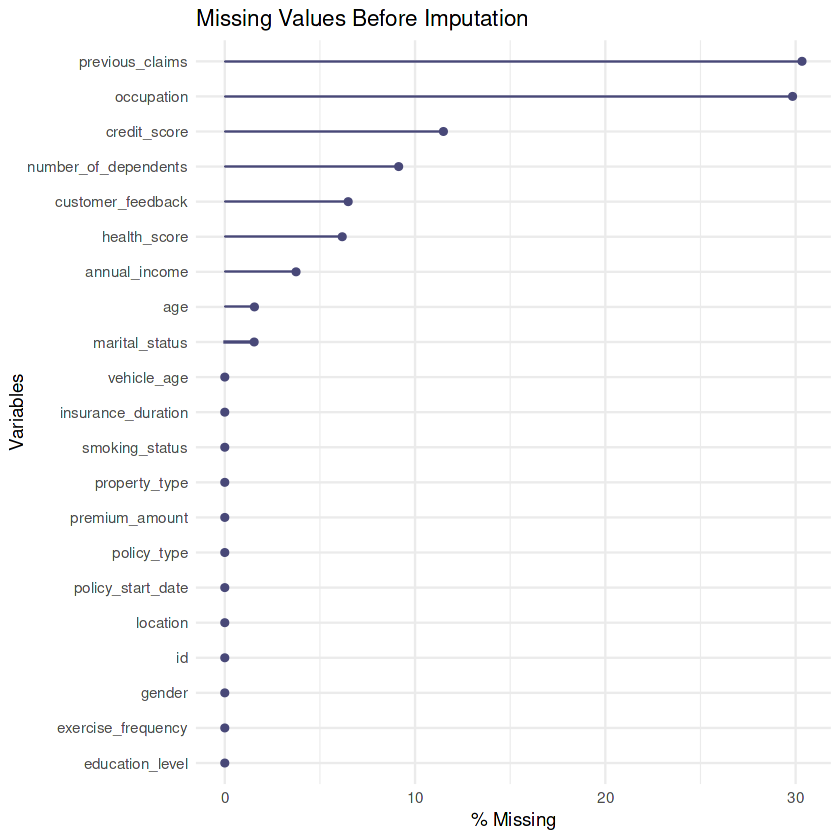

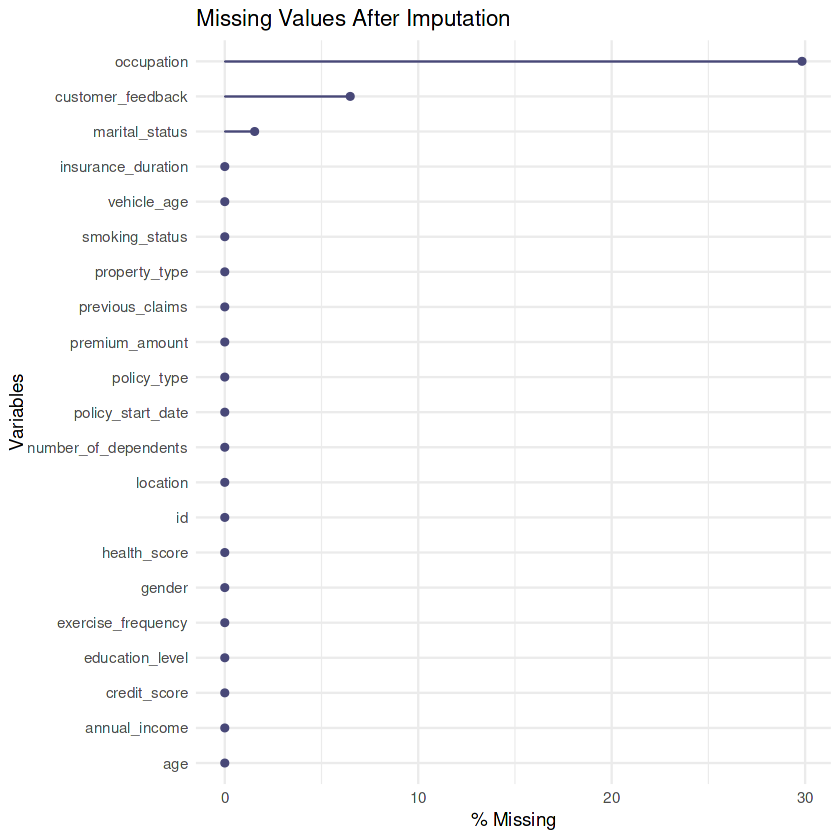

In [7]:
# Visualize missing data before imputation
gg_miss_var(train_before, show_pct = TRUE) + ggtitle("Missing Values Before Imputation")

# Visualize missing data after imputation
gg_miss_var(train_clean, show_pct = TRUE) + ggtitle("Missing Values After Imputation")

In [8]:
train_clean <- train_clean %>%
  # Convert character columns to factors
  mutate(across(
    c(marital_status, education_level, occupation, location, policy_type, 
      customer_feedback, smoking_status, exercise_frequency, property_type), 
    as.factor
  )) %>%
  # Convert appropriate columns to numeric
  mutate(across(
    c(annual_income, number_of_dependents, insurance_duration, vehicle_age, premium_amount),
    as.numeric
  )) %>%
  # Convert policy_start_date to Date
  mutate(policy_start_date = as.Date(policy_start_date, format = "%Y-%m-%d")) %>%
  # Drop remaining NA rows
  drop_na()

In [ ]:
sapply(train_clean[sapply(train_clean, is.numeric)], function(x) sum(!grepl("^\\s*[-+]?[0-9]*\\.?[0-9]+\\s*$", x)))

In [ ]:
numeric_vars <- c('age', 'annual_income', 'number_of_dependents', 'health_score', 'previous_claims', 'vehicle_age', 'credit_score', 'insurance_duration', 'premium_amount')

# Reshape the data
df_long <- train_clean %>% 
  select(all_of(numeric_vars)) %>% 
  pivot_longer(cols = everything(), names_to = "variable", values_to = "value")

# Create the plot
ggplot(df_long, aes(x = variable, y = value, fill = variable)) +
  geom_violin(trim = FALSE, scale = "width") +
  coord_flip() +
  theme_minimal() +
  labs(title = "Distribution of Numeric Variables",
       x = "Variables",
       y = "Values") +
  theme(legend.position = "none")

In [ ]:
# Check for correlation
numeric_vars <- c('age', 'annual_income', 'number_of_dependents', 'health_score', 'previous_claims', 'vehicle_age', 'credit_score', 'insurance_duration', 'premium_amount')

# Create correlation matrix
cor_matrix <- cor(train_clean[numeric_vars], use = "complete.obs")

# Visualize correlation matrix
library(corrplot)
corrplot(cor_matrix, method = "color", type = "upper", order = "hclust", 
         tl.col = "black", tl.srt = 45)

In [ ]:
# check for negative values before log transform
negative_values <- train$premium_amount[train$premium_amount < 0]


In [ ]:
# Scale the specified columns and apply log transformation to premium_amount
train_clean <- train_clean %>%
  mutate(
    annual_income = scale(annual_income),
    age = scale(age),
    health_score = scale(health_score),
    vehicle_age = scale(vehicle_age),
    credit_score = scale(credit_score),
    insurance_duration = scale(insurance_duration),
    premium_amount = log(premium_amount + 1)  # Add 1 to avoid issues with log(0)
  )


# Modeling

In [ ]:
# Splitting the data
set.seed(123)
train_index <- createDataPartition(train_clean$premium_amount, p = 0.8, list = FALSE)
train_set <- train_clean[train_index, ]
test_set <- train_clean[-train_index, ]

In [ ]:
# Set seed for reproducibility
set.seed(123)

# Splitting the data
train_index <- createDataPartition(train_clean$premium_amount, p = 0.8, list = FALSE)
train_set <- train_clean[train_index, ]
test_set <- train_clean[-train_index, ]

# Split features and target variable for train set
X_train <- train_set[, !(names(train_set) %in% c("id", "premium_amount", "policy_start_date"))]
y_train <- train_set$premium_amount

# Split features and target variable for test set
X_test <- test_set[, !(names(test_set) %in% c("id", "premium_amount", "policy_start_date"))]
y_test <- test_set$premium_amount

In [ ]:
# Prepare data
train_matrix <- as.matrix(train_set %>% select(-premium_amount))
train_label <- train_set$premium_amount
test_matrix <- as.matrix(test_set %>% select(-premium_amount))

# Create LightGBM dataset
lgb_train <- lgb.Dataset(data = train_matrix, label = train_label)

# Train the model
lgb_model <- lgb.train(
  params = list(objective = "regression", metric = "rmse", boosting_type = "gbdt"),
  data = lgb_train,
  nrounds = 100,
  learning_rate = 0.1,
  num_leaves = 31
)

# Predict and evaluate
pred_lgb <- predict(lgb_model, test_matrix)
lgb_rmse <- sqrt(mean((pred_lgb - test_set$premium_amount)^2))

# Calculate and print target variable range
target_range <- range(test_set$premium_amount, na.rm = TRUE)
cat("Target variable (premium_amount) range:", target_range[1], "to", target_range[2], "\n")
cat("LightGBM RMSE:", lgb_rmse, "\n")

# Calculate and print percentage RMSE
percentage_rmse <- (lgb_rmse / mean(test_set$premium_amount)) * 100
cat("Percentage RMSE:", round(percentage_rmse, 2), "%\n")

In [ ]:
lgb.importance(lgb_model) %>%
  lgb.plot.importance()